# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]

#progress bar
from tqdm import tqdm_notebook


np.random.seed(2020)
random_state=2020

pd.options.display.max_rows = None
pd.options.display.max_columns = None

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias_original = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [8]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs

#check missing data prior to converting missing or unknown data using feat_info dataset
missing_perc_orig =( (azdias.isnull().sum()/azdias.shape[0]) * 100 ).sort_values(ascending=False)
missing_perc_orig

KK_KUNDENTYP             65.596749
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_BAUMAX             14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
REGIOTYP                 13.598872
KKK                      13.598872
PLZ8_ANTG3               13.073637
PLZ8_ANTG1               13.073637
PLZ8_GBZ                 13.073637
PLZ8_ANTG2               13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
W_KEIT_KIND_HH           12.073549
KBA13_ANZAHL_PKW         11.871354
CAMEO_INTL_2015          11.106000
CAMEO_DEU_2015           11.106000
CAMEO_DEUG_2015          11.106000
ORTSGR_KLS9              10.908181
ARBEIT                   10.908181
RELAT_AB                 10.908181
ANZ_HH_TITEL             10.884842
BALLRAUM                 10.518154
EWDICHTE                 10.518154
INNENSTADT          

## Cleaning/parsing the dataset

##### Assign column names to col_names variable
```
col_names = azdias.columns
```

##### Set a new index for feat_info using the 'attribute' column, which will be used for mapping
```
feat_info.set_index('attribute', inplace=True)
```

##### Convert missing or unknown data to np.nan
```
for col in tqdm_notebook(col_names):
    azdias[col] = azdias[col].map(lambda x: np.nan if str(x) in feat_info.loc[col].missing_or_unknown.strip('[').strip(']').split(',') else x)
```

##### Check cleaned/parsed data
```
azdias.describe()
```

## Additional cleaning of the dataset

Since it took quite some time to run the previous parsing code, I decided to clean it 'manually'

##### Clean columns where 9 was not replaced with NaNs
```
to_clean = ['ARBEIT', 'RELAT_AB']

for col in to_clean:
    azdias[col] = azdias[col].map(lambda x: np.nan if x == 9 else x)
```

##### Check cleaned/parsed data
```
azdias.describe()
```

##### Clean columns where 0 was not replaced with NaNs
```
to_clean = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'TITEL_KZ', 'ALTER_HH',
           'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'KBA05_BAUMAX', 'KKK', 'REGIOTYP', 'ORTSGR_KLS9']

for col in to_clean:
    azdias[col] = azdias[col].map(lambda x: np.nan if x == 0 else x)
```

##### Check cleaned/parsed data
```
azdias.describe()
```

##### Save cleaned/parsed data as a new dataframe after the additional cleaning
```
azdias.to_csv('azdias_converted.csv', sep=';', index = False)
```

In [10]:
# read cleaned/parsed data
azdias = pd.read_csv('azdias_converted.csv', delimiter=';')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

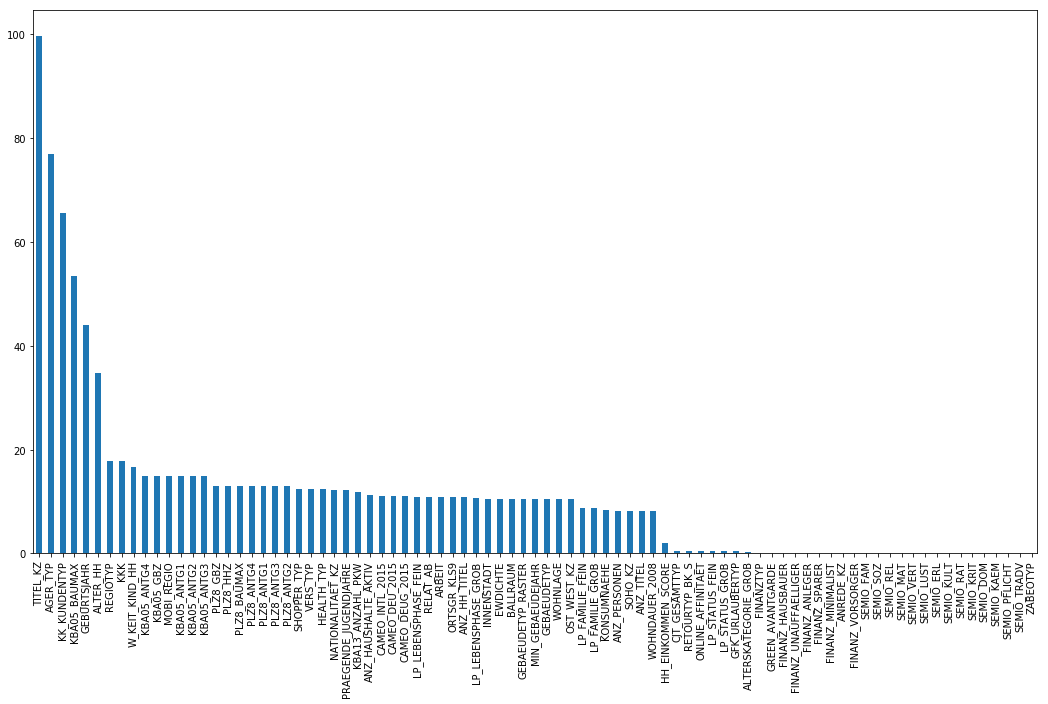

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_perc =( (azdias.isnull().sum()/azdias.shape[0]) * 100 ).sort_values(ascending=False)
missing_perc.plot.bar(figsize=(18,10), color=base_color);

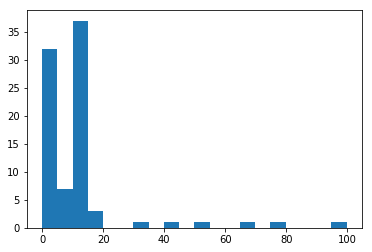

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_perc, bins=20, color=base_color);

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outliers = [col for col in azdias.columns if missing_perc[col] > 20]
outliers

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [14]:
# Drop outlier columns
azdias = azdias.drop(outliers,axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

- Looking at the bar plot and the histogram distribution of columns with missing data, we see that most of them have below 20%. Therefore, I removed these columns from the dataset.
- Among the columns that have been removed, some, like: AGER_TYP, GEBURTSJAHR may be important but for this project we should just remove them.

<br>Columns removed from the dataset: 
<br>'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

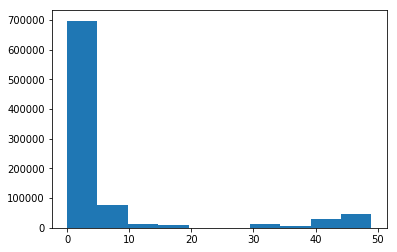

In [15]:
# How much data is missing in each row of the dataset?

missing_rows = azdias.isnull().sum(axis=1)
plt.hist(missing_rows, bins=10, color=base_color);

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

treshold = 20

missing_below_treshold = azdias[missing_rows < treshold].reset_index(drop=True)
missing_above_treshold = azdias[missing_rows >= treshold].reset_index(drop=True)

# Create a new column that defines how much data is missing in each row based on the treshold
azdias['missing_rows'] = missing_rows.apply(lambda x: 'low amount' if x < treshold else 'high amount')

In [17]:
# Check the % of rows with missing data above the threshold
print(missing_above_treshold.shape[0] / azdias.shape[0])

0.10563485375681228


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


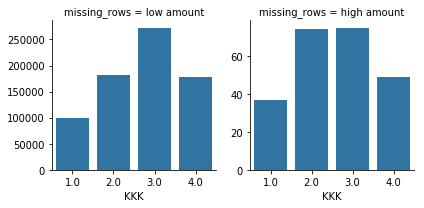

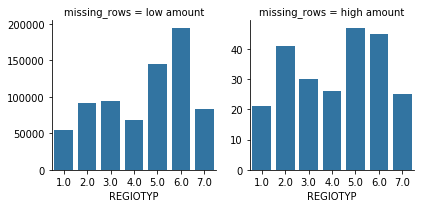

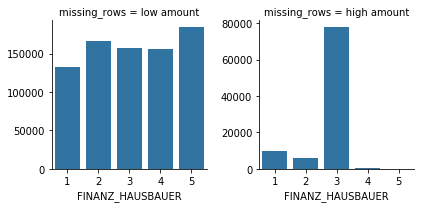

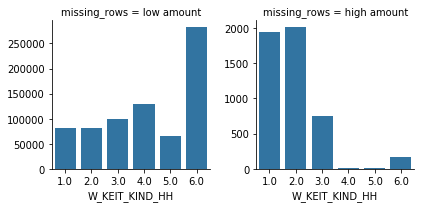

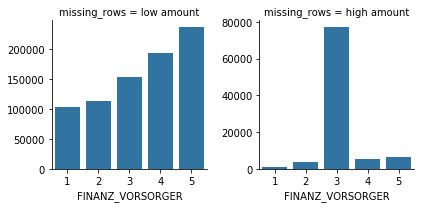

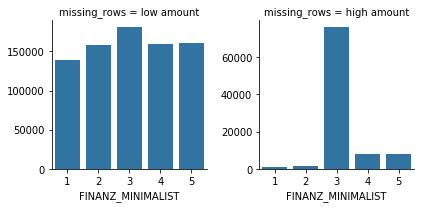

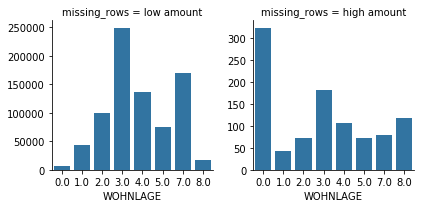

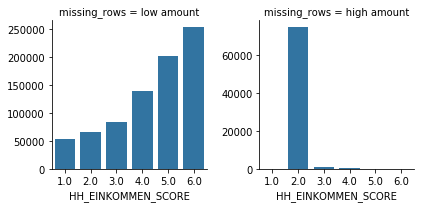

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

col_to_compare = ['KKK', 'REGIOTYP', 'FINANZ_HAUSBAUER', 'W_KEIT_KIND_HH', 'FINANZ_VORSORGER', 'FINANZ_MINIMALIST',
                  'WOHNLAGE', 'HH_EINKOMMEN_SCORE']

for col in col_to_compare:
    g = sns.FacetGrid(azdias, col="missing_rows", col_order=["low amount", "high amount"], sharey=False)
    g.map(sns.countplot, col);

In [19]:
# Drop rows with more than 20 missing features
azdias = azdias[missing_rows < treshold].reset_index(drop=True)

In [20]:
# Fill in the missing values with the most common value for the feature
azdias = azdias.fillna(azdias.mode().iloc[0])

In [21]:
# Drop missing rows column
azdias = azdias.drop(['missing_rows'], axis=1)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- Around 10.5% of rows have more than 20 values missing. For those rows, the distribution of values for the above chosen features is different than for those with less missing values. For this project we should keep the data with no or less missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?

feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_feats = feat_info[feat_info.type == 'categorical']
cat_feats

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [24]:
# Separate binary and non-binary categorical features

binary_cats = []
non_binary_cats = []


for col in cat_feats.attribute.values:
    if azdias[col].nunique() > 2:
        non_binary_cats.append(col)
    else:
        binary_cats.append(col)

### Binary Features

In [25]:
# Show the values and its count for binary features

for col in binary_cats:
    print(azdias[col].value_counts())

2    415578
1    381499
Name: ANREDE_KZ, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
2.0    430454
1.0    366623
Name: VERS_TYP, dtype: int64
W    628695
O    168382
Name: OST_WEST_KZ, dtype: int64


In [26]:
# Encode 'W' as 0 and 'O' as 1 for 'OST_WEST_KZ' feature
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map(lambda x: 0 if x == 'W' else 1)

# Encode '2 as 0'(female) and keep '1' as 1 (male) for 'ANREDE_KZ' feature
azdias['ANREDE_KZ'] = azdias['ANREDE_KZ'].map(lambda x: 0 if x == 2 else 1)

# Encode '2 as 0'(individualistic-accepting risks) and keep '1' as 1 (social-safety driven) for 'VERS_TYP' feature
azdias['VERS_TYP'] = azdias['VERS_TYP'].map(lambda x: 0 if x == 2 else 1)

In [27]:
# Reduce the dataframe memory usage by converting binary features datatypes to uint8

for col in binary_cats:
    azdias[col] = azdias[col].astype(np.uint8)

### Non-binary Features

In [28]:
# Show the values and its count for non-binary features

for col in non_binary_cats:
    print(azdias[col].value_counts())

4.0    202721
3.0    147068
2.0    141166
5.0    111032
6.0    101898
1.0     93192
Name: CJT_GESAMTTYP, dtype: int64
6    289004
1    196805
5    106220
2    104577
4     55874
3     44597
Name: FINANZTYP, dtype: int64
12.0    134615
10.0    102748
8.0      82992
11.0     75051
5.0      70468
4.0      60413
9.0      57046
3.0      53094
1.0      50640
2.0      43647
7.0      40642
6.0      25721
Name: GFK_URLAUBERTYP, dtype: int64
1.0     433230
10.0    128902
2.0      98491
11.0     48727
8.0      21777
7.0      19568
4.0      11573
5.0      11164
9.0      10451
6.0       8512
3.0       4682
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    433230
5.0    188080
2.0     98491
4.0     49857
3.0     27419
Name: LP_FAMILIE_GROB, dtype: int64
1.0     211398
9.0     136229
10.0    111538
2.0     111016
4.0      73938
3.0      68893
6.0      28870
5.0      27472
8.0      18525
7.0       9198
Name: LP_STATUS_FEIN, dtype: int64
1.0    322414
2.0    170303
4.0    154754
5.0    111538
3.0     38068
Na

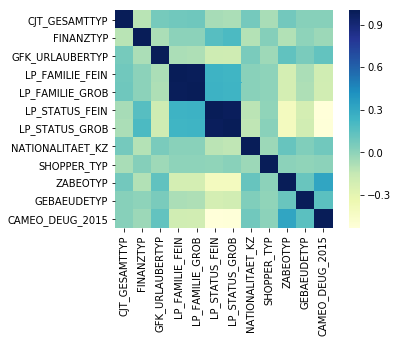

In [29]:
# Check the correlation between the categorical features

sns.heatmap(azdias[non_binary_cats].corr(), cmap="YlGnBu", square=True);

#### Conclusion
- Based on the correlogram, there is a high correlation between LP_FAMILIE_FEIN and LP_FAMILIE_GROB, and LP_STATUS_FEIN and LP_STATUS_GROB, what would make sense looking also at the data dictionary, as 'GROB' is a rough scale and 'FEIN' a fine, more detailed one.
- Moreover, looking at the data dictionary, the same relation exist for CAMEO_DEUG_2015 and CAMEO_DEU_2015 (Wealth / Life Stage Typology, rough and detailed scale accordingly).
- For reducing the number of features that needs to be turned into dummy variables (and to simplify) I am going to drop LP_FAMILIE_FEIN, LP_STATUS_FEIN and CAMEO_DEU_2015.

In [30]:
# Drop above mentioned features

azdias = azdias.drop(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1)

In [31]:
# Remove dropped features from non_binary_cats feature list

removed_cols = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']
non_binary_cats = list(set(non_binary_cats).difference(removed_cols))
non_binary_cats

['FINANZTYP',
 'SHOPPER_TYP',
 'GEBAEUDETYP',
 'CJT_GESAMTTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'ZABEOTYP',
 'CAMEO_DEUG_2015',
 'NATIONALITAET_KZ',
 'GFK_URLAUBERTYP']

In [32]:
# Change datatype to int, to align with the customers dataset
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(np.int8)

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias = pd.get_dummies(azdias, columns=non_binary_cats)

In [34]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797077 entries, 0 to 797076
Data columns (total 129 columns):
ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                uint8
FINANZ_MINIMALIST        int64
FINANZ_SPARER            int64
FINANZ_VORSORGER         int64
FINANZ_ANLEGER           int64
FINANZ_UNAUFFAELLIGER    int64
FINANZ_HAUSBAUER         int64
GREEN_AVANTGARDE         uint8
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                int64
SEMIO_FAM                int64
SEMIO_REL                int64
SEMIO_MAT                int64
SEMIO_VERT               int64
SEMIO_LUST               int64
SEMIO_ERL                int64
SEMIO_KULT               int64
SEMIO_RAT                int64
SEMIO_KRIT               int64
SEMIO_DOM                int64
SEMIO_KAEM               int64
SEMIO_PFLICHT            int64
SEMIO_TRADV              int64
SOHO_KZ 

#### Discussion 1.2.1: Re-Encode Categorical Features

- Binary features: I kept all of them. I encoded three features to 1-0 values and  converted datatypes to uint8 in order to reduce the dataframe memory usage:
<br>- OST_WEST_KZ: 1 for OST, 0 for WEST
<br>- ANREDE_KZ: 1 for male, 0 for female
<br>- VERS_TYP: 1 for social-safety driven, 0 for individualistic-accepting risks
<br>
<br>
- Non-binary features: as mentioned above, I dropped the following features LP_FAMILIE_FEIN, LP_STATUS_FEIN and CAMEO_DEU_2015 due to high correlation with LP_FAMILIE_GROB, LP_STATUS_GROS and CAMEO_DEUG_2015. The kept features were encoded using one-hot encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Identify mixed type features
mixed_feats = feat_info[feat_info.type == 'mixed']
mixed_feats

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [36]:
# Show the values and its count for non-binary features

for col in mixed_feats.attribute.values:
    print(azdias[col].value_counts())

1.0     108205
5.0      52399
6.0      43324
2.0      37146
8.0      28831
11.0     25356
7.0      24947
29.0     24879
13.0     24810
10.0     24458
31.0     22260
12.0     22214
30.0     21145
15.0     18963
3.0      18752
19.0     18575
37.0     17500
4.0      16477
14.0     16350
20.0     16285
32.0     15761
39.0     15131
40.0     14108
27.0     13795
16.0     13632
38.0     13088
35.0     13011
34.0     12421
9.0      12109
21.0     11965
28.0     11543
24.0     11308
25.0      9843
36.0      9654
23.0      8624
22.0      6830
18.0      6802
33.0      5722
17.0      5486
26.0      3368
Name: LP_LEBENSPHASE_FEIN, dtype: int64
2.0     196180
1.0     131093
3.0     109528
12.0     69481
4.0      51172
5.0      47148
9.0      46024
10.0     38021
11.0     31154
8.0      28706
6.0      27419
7.0      21151
Name: LP_LEBENSPHASE_GROB, dtype: int64
14.0    211157
8.0     141504
10.0     85746
5.0      84649
3.0      53811
15.0     42500
11.0     35729
9.0      33560
6.0      25649
12.0 

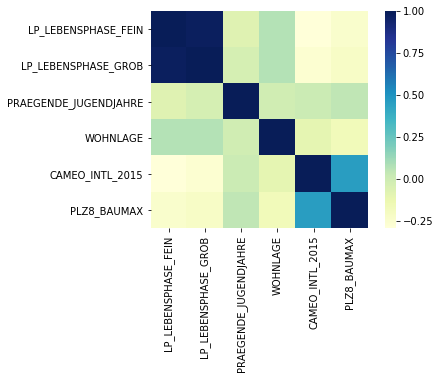

In [37]:
# Check the correlation between the categorical features
mix_feats = mixed_feats.attribute.values
sns.heatmap(azdias[mix_feats].corr(), cmap="YlGnBu", square=True);

In [38]:
# Drop LP_LEBENSPHASE_FEIN due to the high correlation with LP_LEBENSPHASE_GROB
azdias = azdias.drop(['LP_LEBENSPHASE_FEIN'], axis=1)

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def decade(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
def movement(x):
    if x in (1,3,5,8,10,12,14):
        return 1
    else:
        return 0


#Engineer two new features
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(decade)
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(movement)
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def wealth(x):
    if int(x) // 10 == 1:
        return 1
    elif int(x) // 10 == 2:
        return 2
    elif int(x) // 10 == 3:
        return 3
    elif int(x) // 10 == 4:
        return 4
    elif int(x) // 10 == 5:
        return 5
    
def life_stage(x):
    if int(x) % 10 == 1:
        return 1
    elif int(x) % 10 == 2:
        return 2
    elif int(x) % 10 == 3:
        return 3
    elif int(x) % 10 == 4:
        return 4
    elif int(x) % 10 == 5:
        return 5
    
#Engineer two new features
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(wealth)
azdias['CAMEO_INTL_2015_LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(life_stage)
azdias = azdias.drop('CAMEO_INTL_2015', axis=1)

In [41]:
# Reduce the dataframe memory usage by converting features datatypes to uint8

new_feats = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 
             'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']


for col in new_feats:
    azdias[col] = azdias[col].astype(np.uint8)

In [42]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797077 entries, 0 to 797076
Data columns (total 130 columns):
ALTERSKATEGORIE_GROB              float64
ANREDE_KZ                         uint8
FINANZ_MINIMALIST                 int64
FINANZ_SPARER                     int64
FINANZ_VORSORGER                  int64
FINANZ_ANLEGER                    int64
FINANZ_UNAUFFAELLIGER             int64
FINANZ_HAUSBAUER                  int64
GREEN_AVANTGARDE                  uint8
HEALTH_TYP                        float64
LP_LEBENSPHASE_GROB               float64
RETOURTYP_BK_S                    float64
SEMIO_SOZ                         int64
SEMIO_FAM                         int64
SEMIO_REL                         int64
SEMIO_MAT                         int64
SEMIO_VERT                        int64
SEMIO_LUST                        int64
SEMIO_ERL                         int64
SEMIO_KULT                        int64
SEMIO_RAT                         int64
SEMIO_KRIT                        int64


#### Discussion 1.2.2: Engineer Mixed-Type Features

- Due to the high correlation between LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, I decided to drop the more detailed LP_LEBENSPHASE_FEIN. For PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, I followed the project instruction and created 2 new features for each: generation by decade and movement; wealth and life stage. These new features were left as it is.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Changing floats to int16 to reduce the memory usage
floats = azdias.select_dtypes(include=[np.float]).columns
for col in floats:
    azdias[col] = azdias[col].astype(np.int16)

# Change int64 to int8 to reduce the memory usage
ints64 = azdias.select_dtypes(include=[np.int64]).columns
for col in ints64:
    azdias[col] = azdias[col].astype(np.int8)

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Since I have cleaned the dataset on the way, there is not much to do here.
# I will just check the info and visually check if I didn't miss anything.

azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797077 entries, 0 to 797076
Data columns (total 130 columns):
ALTERSKATEGORIE_GROB              int16
ANREDE_KZ                         uint8
FINANZ_MINIMALIST                 int8
FINANZ_SPARER                     int8
FINANZ_VORSORGER                  int8
FINANZ_ANLEGER                    int8
FINANZ_UNAUFFAELLIGER             int8
FINANZ_HAUSBAUER                  int8
GREEN_AVANTGARDE                  uint8
HEALTH_TYP                        int16
LP_LEBENSPHASE_GROB               int16
RETOURTYP_BK_S                    int16
SEMIO_SOZ                         int8
SEMIO_FAM                         int8
SEMIO_REL                         int8
SEMIO_MAT                         int8
SEMIO_VERT                        int8
SEMIO_LUST                        int8
SEMIO_ERL                         int8
SEMIO_KULT                        int8
SEMIO_RAT                         int8
SEMIO_KRIT                        int8
SEMIO_DOM               

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # set the attribute as an idex of the feat_info dataset
    global feat_info
    feat_info.set_index('attribute', inplace=True)
    
    col_names = df.columns
        
    for col in tqdm_notebook(col_names):
        df[col] = df[col].map(lambda x: np.nan if str(x) in feat_info.loc[col].missing_or_unknown.strip('[').strip(']').split(',') else x)
    
    # Clean columns where 9 was not replaced with NaNs
    nine_to_clean = ['ARBEIT', 'RELAT_AB']
    
    for col in nine_to_clean:
        df[col] = df[col].map(lambda x: np.nan if x == 9 else x)
    
    # Clean columns where 0 was not replaced with NaNs
    
    zero_to_clean = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'TITEL_KZ', 'ALTER_HH',
           'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'KBA05_BAUMAX', 'KKK', 'REGIOTYP', 'ORTSGR_KLS9']
    
    for col in zero_to_clean:
        df[col] = df[col].map(lambda x: np.nan if x == 0 else x)
    
    # ================================================================================================
    # remove selected columns and rows, ...
    
    # Columns
    outliers = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(outliers,axis=1)
    
    # Rows
    missing_rows = df.isnull().sum(axis=1)
    treshold = 20
    df = df[missing_rows < treshold].reset_index(drop=True)
    
    # Fill in the missing values with the most common value for the feature
    df = df.fillna(df.mode().iloc[0])
    
    # Filter feat info dataset on clumns that are in the customer df
    feat_info = feat_info[feat_info.index.isin(list(df.columns.values))]
    
    # Categorical features
    cat_feats = feat_info[feat_info.type == 'categorical']
    
    # Separate binary and non-binary categorical features
    binary_cats = []
    non_binary_cats = []
    
    for col in cat_feats.index.values:
        if df[col].nunique() > 2:
            non_binary_cats.append(col)
        else:
            binary_cats.append(col)
    
    # Encode 'W' as 0 and 'O' as 1 for 'OST_WEST_KZ' feature
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(lambda x: 0 if x == 'W' else 1)

    # Encode '2 as 0'(female) and keep '1' as 1 (male) for 'ANREDE_KZ' feature
    df['ANREDE_KZ'] = df['ANREDE_KZ'].map(lambda x: 0 if x == 2 else 1)

    # Encode '2 as 0'(individualistic-accepting risks) and keep '1' as 1 (social-safety driven) for 'VERS_TYP' feature
    df['VERS_TYP'] = df['VERS_TYP'].map(lambda x: 0 if x == 2 else 1)

    # Reduce the dataframe memory usage by converting binary features datatypes to uint8
    for col in binary_cats:
        df[col] = df[col].astype(np.uint8)
    
    # Drop highly correlated non-binary features
    df = df.drop(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1)
    
    # Remove dropped features from non_binary_cats feature list
    removed_cols = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']
    non_binary_cats = list(set(non_binary_cats).difference(removed_cols))
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df = pd.get_dummies(df, columns=non_binary_cats)
    
    # Drop LP_LEBENSPHASE_FEIN due to the high correlation with LP_LEBENSPHASE_GROB
    df = df.drop(['LP_LEBENSPHASE_FEIN'], axis=1)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    def decade(x):
        if x in (1,2):
            return 1
        if x in (3,4):
            return 2
        if x in (5,6,7):
            return 3
        if x in (8,9):
            return 4
        if x in (10,11,12,13):
            return 5
        if x in (14,15):
            return 6

    def movement(x):
        if x in (1,3,5,8,10,12,14):
            return 1
        else:
            return 0

    #Engineer two new features
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    def wealth(x):
        if int(x) // 10 == 1:
            return 1
        elif int(x) // 10 == 2:
            return 2
        elif int(x) // 10 == 3:
            return 3
        elif int(x) // 10 == 4:
            return 4
        elif int(x) // 10 == 5:
            return 5

    def life_stage(x):
        if int(x) % 10 == 1:
            return 1
        elif int(x) % 10 == 2:
            return 2
        elif int(x) % 10 == 3:
            return 3
        elif int(x) % 10 == 4:
            return 4
        elif int(x) % 10 == 5:
            return 5

    #Engineer two new features
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(life_stage)
    df = df.drop('CAMEO_INTL_2015', axis=1)
    
    # Reduce the dataframe memory usage by converting features datatypes to uint8
    new_feats = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 
             'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']
    
    for col in new_feats:
        df[col] = df[col].astype(np.uint8)
    
    # ================================================================================================
    # Changing floats to int16 to reduce the memory usage
    floats = df.select_dtypes(include=[np.float]).columns
    
    for col in floats:
        df[col] = df[col].astype(np.int16)

    # Change int64 to int8 to reduce the memory usage
    ints64 = df.select_dtypes(include=[np.int64]).columns
    
    for col in ints64:
        df[col] = df[col].astype(np.int8)
        
    # ================================================================================================        
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias.isnull().sum().sum()

0

In [47]:
# save cleaned dataset
# azdias.to_csv('population_clean.csv', sep=';', index = False)

In [48]:
# read cleaned dataset
azdias = pd.read_csv('population_clean.csv', delimiter=';')

In [49]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias[azdias.columns] = scaler.fit_transform(azdias[azdias.columns])

### Discussion 2.1: Apply Feature Scaling

- Missing values were replaced earlier with the most frequent values (mode). In this section I applied the StandardScaler for the feature scaling.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.

pca = PCA()
azdias_reduced = pca.fit_transform(azdias)

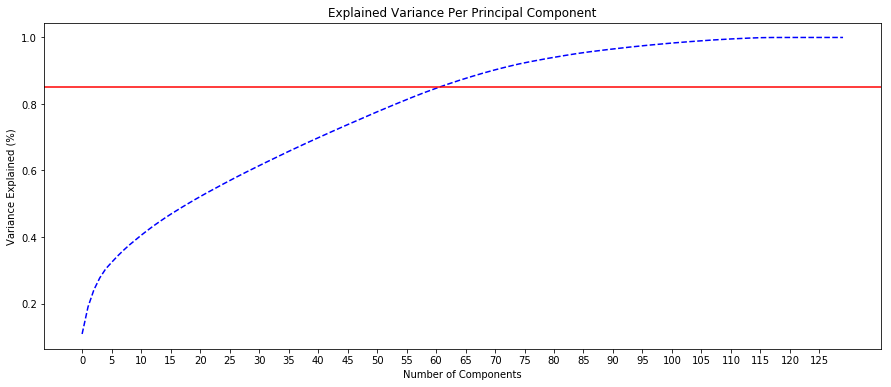

In [51]:
# Investigate the variance accounted for by each principal component.

plt.figure(figsize=(15, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel("Variance Explained (%)") 
plt.xticks(np.arange(0, 130, step=5))
plt.axhline(y=0.85, color='r', linestyle='-')
plt.title('Explained Variance Per Principal Component')
plt.show()   

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=60, random_state=random_state)
azdias_reduced_60 = pca.fit_transform(azdias)

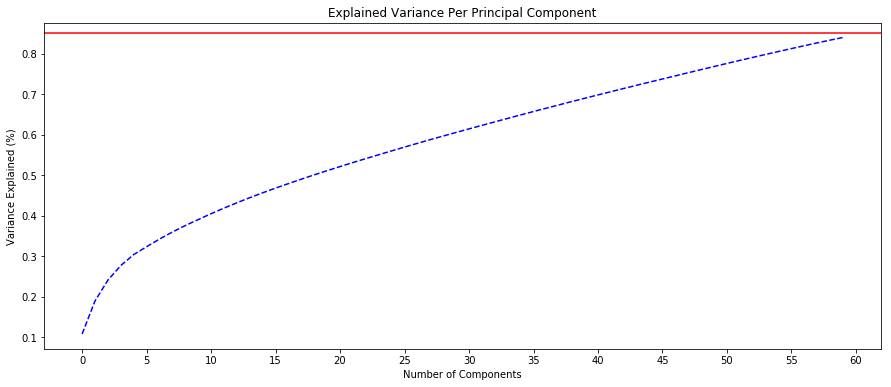

In [53]:
plt.figure(figsize=(15, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel("Variance Explained (%)") 
plt.xticks(np.arange(0, 65, step=5))
plt.axhline(y=0.85, color='r', linestyle='-')
plt.title('Explained Variance Per Principal Component')
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

- Originally, there were 130 features in the dataset. I decided to keep 60 components. In order to get 85% of variance explained I need 60-61 principal components. For the simplicity I will keep 60 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
def pca_results(full_dataset, pca, n):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys()).iloc[n]
    components.sort_values(ascending=False, inplace=True)
    components = pd.concat([components.head(10), components.tail(10)])
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))    
    
    components.plot(ax = ax, kind = 'bar', title='Dimension ' + str(n))
    ax.set_ylabel("Feature Weights")
    plt.show();

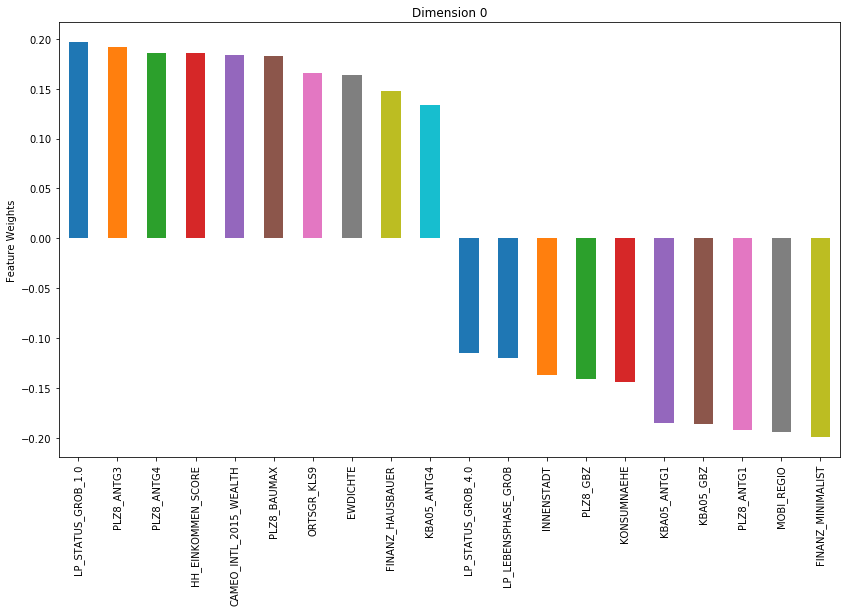

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_results(azdias, pca, 0)

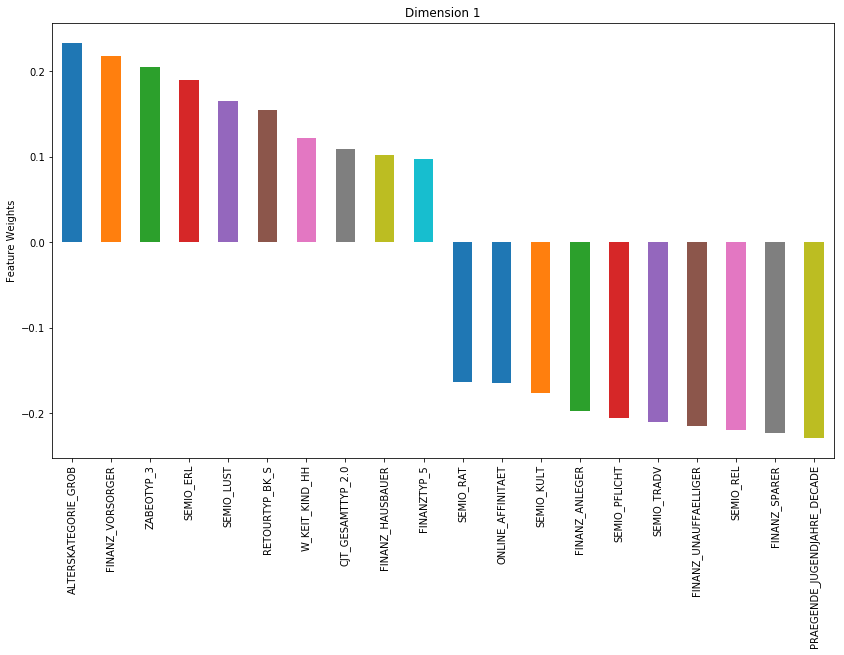

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias, pca, 1)

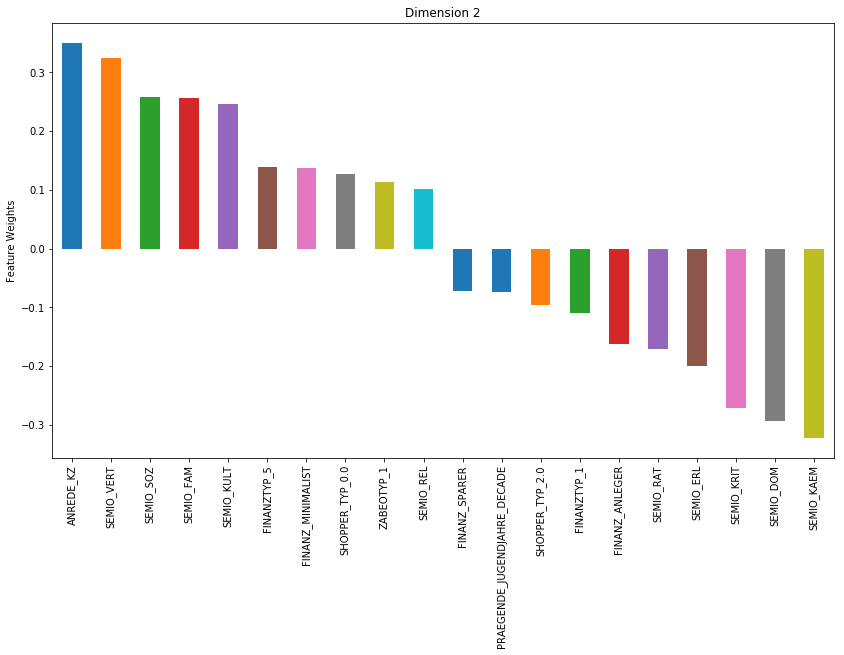

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias, pca, 2)

### Discussion 2.3: Interpret Principal Components

1. The 1st component focuses on the wealth and the type of the neighbourhood people live in. We can observe that this component positively weights items related to lower income and neighbourhoods with 6+ family houses in the PLZ8 region, as opposed to higer income and number of 1-2 family houses in the PLZ8 region.
2. The 2nd component focuses on the age and personal traits. It possitively weights items related to sensual minded and event oriented person, who are precautions with their money, as opposed to religious, dutiful rational and traditional minded people, who are rather money-servers.
3. The 3rd component focuses also on personal traits, along with gender and the financial type. This component positively weights items related to dreamy, cultural, family & social oriented people, who are also investors, as opposed to critical, rational & event oriented people, whe has low financial interest.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

#### The 2 below functions were taken from the course materials, helpers2.py

In [58]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

     # run k-means clustering on the data and..
    model = kmeans.fit(data)

    # compute the average within-cluster distances.
    score = np.abs(model.score(data))

    return score

```
scores = []
centers = list(range(1,31))

for center in tqdm_notebook(centers):
    scores.append(get_kmeans_score(azdias_reduced_60, center))
```

<b>Investigate the change in within-cluster distance across number of clusters.
<br>HINT: Use matplotlib's plot function to visualize this relationship.</b>
```
plt.figure(figsize=(15, 6))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K (# clusters)');
plt.ylabel('SSE (Sum of squared error)');
plt.title('SSE vs. K')

plt.savefig('SSEvsK.png');
```

In [59]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=18, random_state=random_state).fit(azdias_reduced_60)
predict_population = kmeans.predict(azdias_reduced_60)

### Discussion 3.1: Apply Clustering to General Population

- Checking the above plot (to reduce the time and avoid re-computing everything, I marked down the code and saved the plot to png) , we can conclude that there is no obvious elbow - errors keeps decreasing (without a bigger drop) with more clusters. I decided to keep 18 clusters, as around that point we can see slightly steeper drop, followed by small decreases in the SSE with each additional cluster.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [61]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [62]:
# Check the number of records and columns
customers.shape, azdias_original.shape

((191652, 85), (891221, 85))

In [63]:
customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [64]:
azdias_original.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [65]:
# Check if there are additional columns in the customer dataset
columns_diff = list(set(azdias_original.columns)-set(customers.columns))
columns_diff

[]

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

HBox(children=(IntProgress(value=0, max=85), HTML(value='')))

In [67]:
# Check if there are additional columns in the customer dataset
columns_diff = list(set(azdias.columns)-set(customers_clean.columns))
columns_diff

['GEBAEUDETYP_5.0']

In [68]:
# Add the missing column from azdias dataset and set the value to 0
customers_clean['GEBAEUDETYP_5.0'] = 0

In [69]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,GEBAEUDETYP_5.0
0,4,1,5,1,5,1,2,2,1,1,5,5,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0,1,2,0,1,6,9,1,0,5,1992,0,7,2,2,0,0,4,3,2,4,4,1,4,3,1,1201,3,3,1,0,1,5,5,1,2,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,1,3,0
1,4,0,5,1,5,1,4,4,1,2,3,5,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0,0,1,0,1,6,9,1,0,1,1992,0,2,2,2,0,0,3,7,4,1,3,3,3,1,7,433,2,3,3,1,3,3,2,3,5,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,3,4,0
2,4,1,5,1,5,2,1,2,0,2,12,3,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,1,0,0,4,6,9,1,0,2,1992,0,7,3,0,0,0,4,7,1,7,4,3,4,2,6,755,3,2,1,0,1,3,4,1,3,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,4,0
3,3,1,3,1,4,4,5,2,0,3,10,5,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0,0,4,0,6,2,9,7,0,1,1992,0,3,0,3,2,0,3,3,4,4,3,4,3,5,7,513,2,4,2,1,2,3,3,3,5,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,1,4,1,0
4,3,1,5,1,5,1,2,3,1,3,5,3,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0,0,2,0,1,6,9,1,0,2,1992,0,1,2,2,1,0,3,7,5,8,4,2,3,3,3,1167,2,3,2,1,1,5,5,3,7,5,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,3,4,0


In [70]:
# customers_clean.to_csv('customers_clean.csv', sep=';', index = False)

In [71]:
# Load in the clean_customer demographics data.
customers_clean = pd.read_csv('customers_clean.csv',delimiter=';')

In [72]:
# Apply feature scaling to the customers data.

customers_clean[customers_clean.columns] = scaler.transform(customers_clean[customers_clean.columns])

In [73]:
# Apply PCA to the customer data

customers_clean_reduced_60 = pca.transform(customers_clean)

In [74]:
# Predict clustering using the kmeans object

predict_customers = kmeans.predict(customers_clean_reduced_60)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [75]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_clusters = pd.DataFrame(data=predict_population, 
                                   columns=['pop_cluster'])['pop_cluster'].value_counts()/len(predict_population)*100

customer_clusters = pd.DataFrame(data=predict_customers, 
                                 columns=['cust_cluster'])['cust_cluster'].value_counts()/len(predict_customers)*100

In [76]:
population_clusters = population_clusters.sort_index(ascending=True)
customer_clusters = customer_clusters.sort_index(ascending=True)

In [77]:
frames = [population_clusters,customer_clusters]
merged_df = pd.concat(frames, keys=['pop_cluster', 'cust_cluster'], axis=1)

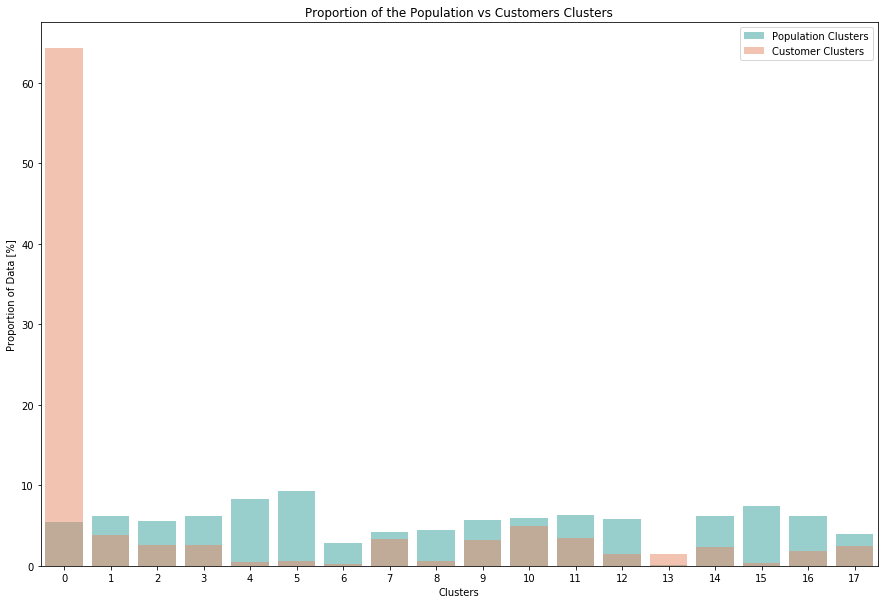

In [78]:
plt.subplots(figsize = (15,10))

# Plot the Proportion of the Population Clusters
sns.barplot(x=merged_df.index, y='pop_cluster', data=merged_df,
            label="Population Clusters", color="lightseagreen", alpha=0.5)

# Plot the Proportion of the Customers Clusters
sns.barplot(x=merged_df.index, y='cust_cluster', data=merged_df,
            label="Customer Clusters", color="coral", alpha=0.5)

plt.title('Proportion of the Population vs Customers Clusters')
plt.legend()
plt.xlabel('Clusters')
plt.ylabel('Proportion of Data [%]');

In [79]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cust_data_cluster_0 = kmeans.cluster_centers_[0]
cust_data_cluster_0 = pd.Series(cust_data_cluster_0)
cust_data_cluster_0.sort_values(ascending=False, inplace=True)
cust_data_cluster_0.head()

1     3.503264
2     3.247021
0     0.896930
13    0.708050
14    0.646320
dtype: float64

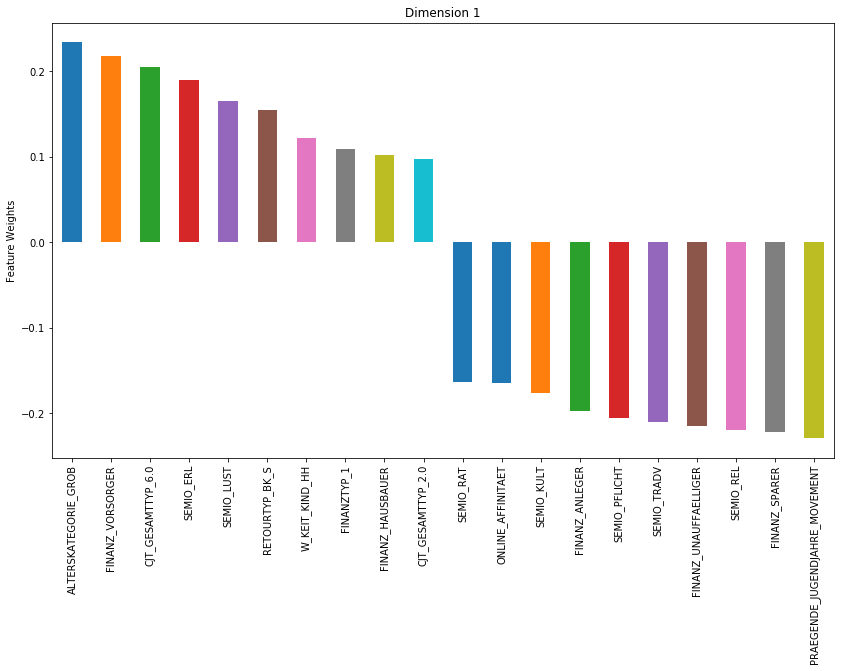

In [80]:
pca_results(customers_clean, pca, 1)

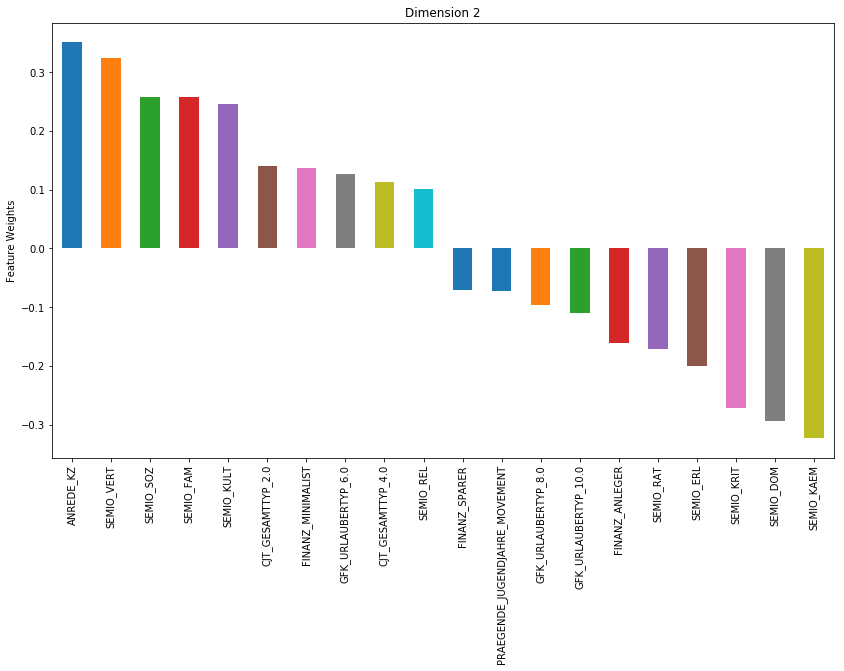

In [81]:
pca_results(customers_clean, pca, 2)

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cust_data_cluster_5 = kmeans.cluster_centers_[5]
cust_data_cluster_5 = pd.Series(cust_data_cluster_5)
cust_data_cluster_5.sort_values(ascending=False, inplace=True)
cust_data_cluster_5.head()

0     5.341206
3     0.615174
10    0.496469
14    0.339242
9     0.298016
dtype: float64

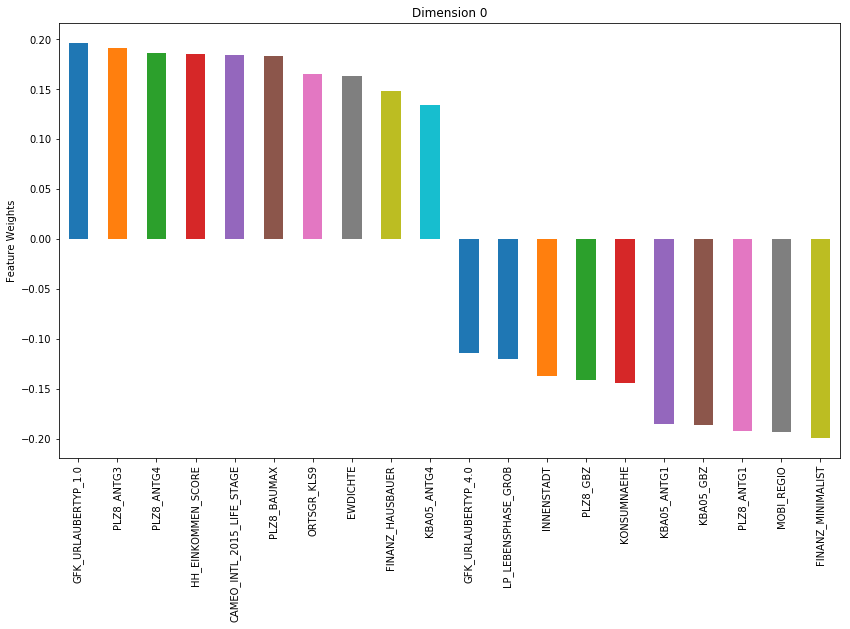

In [83]:
pca_results(customers_clean, pca, 0)

### Discussion 3.3: Compare Customer Data to Demographics Data

- Looking at the above chart we can notice that clusters 4, 5, 6, 15 are unpopular with the mail-order company ane people are less likely to turn into customers. On the other hand people from clusters 0, 7 & 10 are more likely to be customers.
- Cluster 5th is underrepresented in the customer data what would make sense looking at the pca component 0 that positively weights items related to lower income and neighbourhoods with 6+ family houses in the PLZ8 region, as opposed to higer income and number of 1-2 family houses in the PLZ8 region.
- Cluster 0 is overrepresented in the customer data compared to the general population. These are more cultural, family & social oriented people, who like online shopping, as opposed to religious, dutiful rational and traditional minded people, who are rather money-servers.
<br>
<br> **General conclusion**
- It looks like the company is doing well with ypunger, open minded people, who are prone to online shopping, what makes sense as the company relies on sales. The conclusion is based on the components investigated above, investigating more components would be really time consuming and I think it is beyond the scope of this task (along with trying different scaling methods and different clustering algorithms)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.